## ALMA imaging

This notebook aims to show the basics of how the Atacama Large Millimeter/submillimeter Array (ALMA) generates images through interferometry. ALMA is located in the Atacama Desert in Chile and is composed of a main array of 66 12-meter radio dishes and a small compact array of 12 7-meter radio dishes. These dishes are moved into different configurations over the span of an observing cycle. The longest baseline can vary between 150m (compact array) to 16km.

<div>
<img src="j9d2RPbtyAGLGQHBawQ7zD-1024-80.jpg" width="600"/>
</div>

### Defining coordinate systems

Radio astronomy (and astronomy in general) uses multiple coordinate systems. The most intuitive of those is the <b>geographic coordinate system</b> used to describe locations on the surface of the earth. These coordinates are given in longitude and latitude. This system is how we will define the coordinates of the observatory (ALMA).

ALMA provides configuration files for the different array setups that will be used through the observing season. These configuration files are given in the <b>local tangent plane system</b>, with coordinates "east", "north", and "up." The reference is defined by the local vertical direction (up, which is tangent to Earth's surface) and then by the rotation of the Earth (giving the east coordinate). The north coordinate is simply a 90 degree rotation of the east coordinate. This is a useful system for accurately describing the relative distances of objects on a local scale without spherical geometry.

However, these coordinates are inconvenient for some applications since they depend on where the center of the coordinate system is defined. Thus, we will want to transform the ENU coordinates to coordinates which are aligned with Earth's rotational axis, taking out the location dependence. These are called <b>Earth-Centered Earth-Fixed</b> (ECEF) coordinates and use variables (x,y,z). The transformation accounts for the angle between the center of the ENU plane and the rotational axis of the earth.

<div>
<img src="ECEF_ENU_Longitude_Latitude_relationships.svg.png" width="400"/>
</div>

Significant credit is given to Prof. Dale E. Gary's [course notes](https://web.njit.edu/~gary/728/Lecture6.html) for Physics 728 at the New Jersey Institute for Technology for providing the coordinate transformations from the local tangent plane to the xyz- and uv-planes.

In [58]:
# Python 3.7.4
import pandas as pd # 1.3.5
import numpy as np # 1.21.6
import matplotlib.pyplot as plt # 3.3.2

# define coordinates of ALMA (longitude and latitude)
lat = -23.0234
lat_rad = lat/180. * np.pi # in radians
lon = -67.7538
lon_rad = lon/180. * np.pi # in radians
altitude = 5058.7 # meters

# read in coordinates of ALMA cycle 7 array configuration 1, this is identical to cycle 9 configuration
#######
# Optional exercise:
# Try changing this to a different configuration file to see how it changes the answers throughout
# Configuration files are included on the Github and follow the naming convention: alma.cycle7.x.cfg (x:{1:10})
# Currently, it is set to the compact array (aca), which is the smallest, tightest configuration
#######
df = pd.read_csv('aca.cycle7.cfg', sep=' ')

# coordinates are given in local tangent plane (East North Up) in meters
E = df['x'].to_numpy()
N = df['y'].to_numpy()
U = df['z'].to_numpy()

# convert ENU to xyz (coordinate system aligned with Earth's rotational axis) in meters
x = -N * np.sin(lat_rad) + U * np.cos(lat_rad)
y = E
z = N * np.cos(lat_rad) + U * np.sin(lat_rad)

### Calculating baselines

Now we want to calculate the length of all of the baselines in the ECEF system. Baselines are the distance between respective antennas on the array. There should thus be $\frac{N(N-1)}{2}$ total unique baselines for a given system where $N$ is the number of antennas. This means with ALMA's 66 12-meter array, there should be a total of 2145 baselines. Each baseline contributes two samples in the uv-plane, so the number of baselines (antennas) directly influences how complete the final image is.

The uv-plane is the wavelength sampling plane. Thus, we wish to project our baselines into this plane to determine what wavelengths/frequencies we will measure. We invert the uv-plane in order to obtain dirty images (so called because they are inversions of incomplete information and thus will contain artefacts). The image plane is called the lm-plane, and this is the information we sample with the uv points.

Longer baselines correspond to smaller angular scales on the sky. An approximate relation is FWHM (") = 76 / max_baseline (km) / frequency (GHz). This means you want to use a very wide array to get high resolution of small scale details of emission, or conversely, a very compact array to observe extended emission.

<div>
<img src="uvw.gif" width="400"/>
</div>

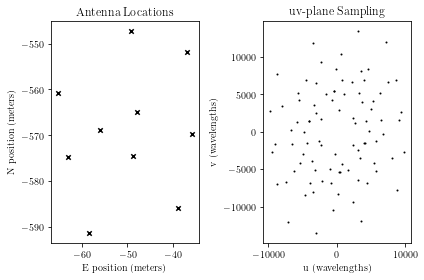

In [59]:
# use xyz coordinate system to calculate baselines

# set target's hour angle (relative to local meridian) and declination (relative to celestial equator)
# currently the target is set to be directly overhead

h0 = 0.0 # hour angle (radians)
d0 = 0.0 # declination (radians)

# calculate all baselines, removing coordinates that are matches with themselves (i.e. baseline length = 0)
# leave in redundant baselines (B = -B) to represent the two uv samples
Bx_init = np.array([x - xcoord for xcoord in x]).flatten()
Bx = Bx_init[Bx_init!=0]
By_init = np.array([y - ycoord for ycoord in y]).flatten()
By = By_init[By_init!=0]
Bz_init = np.array([z - zcoord for zcoord in z]).flatten()
Bz = Bz_init[Bz_init!=0]

# calculate coordinates projected into the uv-plane (wavelength units)

##########
# Exercise:
# change the central wavelength of the observations to see how the uv-sampling responds
##########

lamb = 3e-3 # 3mm wavelength

# coordinate transformations into the uv-plane
u = 1/lamb * ( np.sin(h0)           *Bx + np.cos(h0)           *By                )
v = 1/lamb * (-np.sin(d0)*np.cos(h0)*Bx + np.sin(d0)*np.sin(h0)*By + np.cos(d0)*Bz)
w = 1/lamb * ( np.cos(d0)*np.cos(h0)*Bx - np.cos(d0)*np.sin(h0)*By + np.sin(d0)*Bz)

# plot the locations of the antennas and the resulting uv-plane sampling
fig, ax = plt.subplots(1,2)
ax[0].scatter(E, N, color='black', s=20, marker='x')
ax[0].set_xlabel('E position (meters)')
ax[0].set_ylabel('N position (meters)')
ax[0].set_title('Antenna Locations')
ax[1].scatter(u, v, color='black', s=1)
ax[1].set_xlabel('u (wavelengths)')
ax[1].set_ylabel('v (wavelengths)')
ax[1].set_title('uv-plane Sampling')
fig.tight_layout()
plt.show()

#### Earth Rotation Aperture Synthesis

Fortunately, we can use the Earth's rotation to improve our sampling of the uv-plane. uv samplings follow "uv-tracks" through the observation. This is because the projection of the baseline onto the uv-plane changes based on its angle on the Earth's surface relative to the observed object.

<div>
<img src="Screen%20Shot%202022-05-31%20at%2010.18.28%20AM.png" width="500"/>
</div>

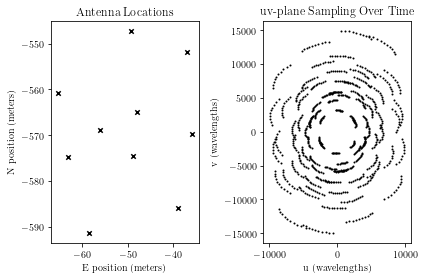

In [60]:
# calculate now for multihour observations

nsamples = 10 # number of samples taken over the observations (will fill in uv-plane)
obs_length = 6 # hours, no new information is gained after 12 hours, try changing to see what it does!!

h0 = np.linspace(-obs_length/48 * np.pi, obs_length/48 * np.pi, nsamples) # radians
d0 = np.array([-30 / 180 * np.pi] * 10) # degrees, remember latitude of ALMA is -23 degrees 

u = 1/lamb * np.array([( np.sin(h0[i])              *Bx + np.cos(h0[i])              *By                   ) \
                       for i in range(len(h0))]).flatten()
v = 1/lamb * np.array([(-np.sin(d0[i])*np.cos(h0[i])*Bx + np.sin(d0[i])*np.sin(h0[i])*By + np.cos(d0[i])*Bz) \
                       for i in range(len(h0))]).flatten()
w = 1/lamb * np.array([( np.cos(d0[i])*np.cos(h0[i])*Bx - np.cos(d0[i])*np.sin(h0[i])*By + np.sin(d0[i])*Bz) \
                       for i in range(len(h0))]).flatten()

fig, ax = plt.subplots(1,2)
ax[0].scatter(E, N, color='black', s=20, marker='x')
ax[0].set_xlabel('E position (meters)')
ax[0].set_ylabel('N position (meters)')
ax[0].set_title('Antenna Locations')
ax[1].scatter(u, v, color='black', s=1)
ax[1].set_xlabel('u (wavelengths)')
ax[1].set_ylabel('v (wavelengths)')
ax[1].set_title('uv-plane Sampling Over Time')
fig.tight_layout()
plt.show()

### Imaging: Visibilities and the Sampling Function

Now that we have synthesized the uv-plane, we need to figure out how to obtain images from the finite sampling. 

The sampling function $S(u,v)$ describes where we measure data in the uv-plane. Its value is equal to the 2D delta function where we have taken data and 0 elsewhere. <b>The fourier transform of the sampling function is the synthesized beam.</b>

For a given sky brightness distribution $I(l,m)$ (i.e. the radiation you are trying to image) there exists a visibility function. <b>The visibility function $V(u,v)$ is the fourier transform of the sky brightness distribution</b>, and is thus a complex valued continuous function everywhere. Given perfect sampling of the visibility function, the exact sky brightness distribution can be reconstructed. The actual information we obtain from the array is given by the multiplication of the sampling function by the visibility function $S(u,v)V(u,v)$.

The image we wish to obtain is given by the inverse fourier transform of $S(u,v)V(u,v)$. By the convolution theorem, this is exactly equivalent to the fourier transform of the sampling function (the synthesized beam) convolved with the visibility function.

$\mathcal{F}(S(u,v)) * V(u,v) = \mathcal{F}(S(u,v)) * \mathcal{F}(I(l,m))$

This is exactly equivalent to saying that the image obtained is the convolution of the synthesized beam with the fourier transform of the sky.

All of the code below is reconstructing sampled images of different types of sources (point source, disk, extended gaussian source, two extended gaussian sources, and an extended elliptical source). Play around with different antenna configurations, sampling schemes, wavelengths, etc. to find out how different parameters affect the reconstructed image.

Credit to [this Stack Exchange](https://astronomy.stackexchange.com/questions/44853/if-the-visibility-function-is-the-fourier-transform-of-the-sky-brightness-distri) for helping me understand that the image we sample is simply the synthesized beam convolved with the true brightness distribution, just like in optical astronomy.

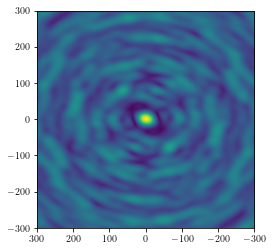

In [61]:
# calculating the synthesized beam (PSF equivalent)
# this will be convolved with our sources below to generate simulated images

import matplotlib.colors as mcolors

arcsec_2_rad = 1.0/206264.806 # arcseconds -> radians
lm_extent = 300. # size of image (arcsec)

# make the l,m plane grids
lm_grid = np.arange(-lm_extent/2, lm_extent/2, 0.5)*arcsec_2_rad
l, m = np.meshgrid(lm_grid, lm_grid)
# initialize an empty beam
PSF = np.zeros_like(l)
# add the sampled visibilities to the beam, setting them equal to 1 with imaginary component 0
for i in range(len(u)):
    PSF += 2. * np.cos(2. * np.pi * (u[i]*l + v[i]*m))
# normalize the beam to a maximum response of 1
PSF/= np.max(PSF)

# plot the beam
fig, ax = plt.subplots()
ax.imshow(PSF, origin='lower', extent=(lm_extent, -lm_extent, -lm_extent, lm_extent), norm=mcolors.PowerNorm(0.5))
plt.show()

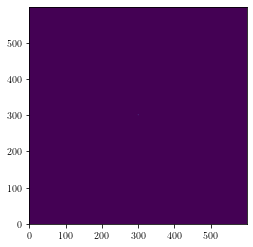

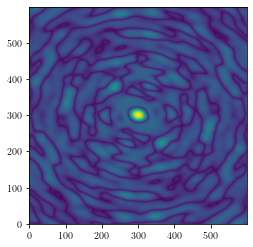

In [62]:
# POINT SOURCE

sky = np.zeros(np.shape(PSF))
N = len(sky)
sky[int(N/2),int(N/2)] = 1. # convolve with a point source at center
im=  np.fft.fft2(np.fft.fftshift(sky))
im*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))
im = np.fft.fftshift(np.fft.ifft2(im))

plt.imshow(sky, origin='lower')
plt.show()

plt.imshow(abs(im), origin='lower',  norm=mcolors.PowerNorm(0.5))
plt.show()

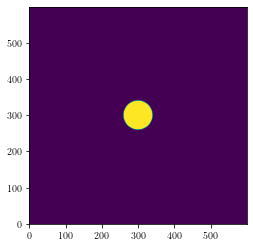

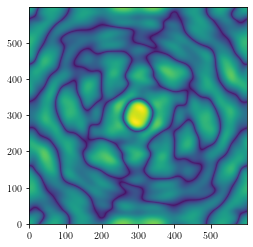

In [63]:
# CONSTANT EMISSION DISK

sky = np.zeros(np.shape(PSF))
N = len(sky)
L=60
Diam=8 # change diameter of disk here

y,x = np.meshgrid(np.linspace(-L/2,L/2,N),
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)

sky[r<Diam/2] = 1. # generate a disk of constant emission
#plt.imshow(sky)
#plt.show()
im=  np.fft.fft2(np.fft.fftshift(sky))
im*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))
im = np.fft.fftshift(np.fft.ifft2(im))

plt.imshow(sky, origin='lower')
plt.show()

plt.imshow(abs(im), origin='lower',  norm=mcolors.PowerNorm(0.5))
plt.show()

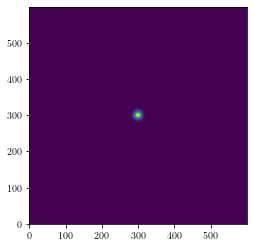

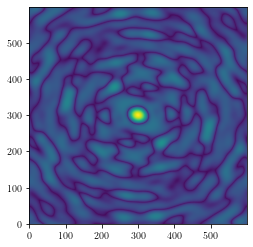

In [64]:
# GAUSSIAN SOURCE

sky = np.zeros(np.shape(PSF))
N = len(sky)
L=60
Diam=1 # change size of source here

y,x = np.meshgrid(np.linspace(-L/2,L/2,N),  ## cartesian coordinates
                  np.linspace(-L/2,L/2,N))
r = np.sqrt(x**2 + y**2)

sky = np.exp(-r**2 / Diam**2) # generate a Gaussian source with sigma = Diameter
im=  np.fft.fft2(np.fft.fftshift(sky))
im*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))
im = np.fft.fftshift(np.fft.ifft2(im))

plt.imshow(sky, origin='lower')
plt.show()

plt.imshow(abs(im), origin='lower',  norm=mcolors.PowerNorm(0.5))
plt.show()

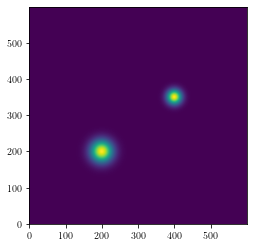

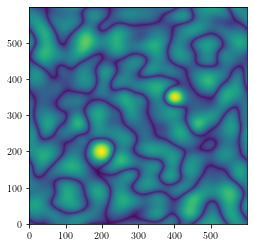

In [65]:
# TWO GAUSSIAN SOURCES

source1_cent = (-10, -10)
source2_cent = (5, 10)

Diam1 = 3 # change size of source 1 here
Diam2 = 2 # change size of source 2 here

r1 = np.sqrt((x - source1_cent[0])**2 + (y - source1_cent[1])**2)
r2 = np.sqrt((x - source2_cent[0])**2 + (y - source2_cent[1])**2)

sky = np.exp(-r1**2 / Diam1**2) + np.exp(-r2**2 / Diam2**2) # generate a map of two gaussian sources

plt.imshow(sky, origin='lower')
plt.show()

im=  np.fft.fft2(np.fft.fftshift(sky))
im*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))
im = np.fft.fftshift(np.fft.ifft2(im))

plt.imshow(abs(im), origin='lower',  norm=mcolors.PowerNorm(0.5))
plt.show()

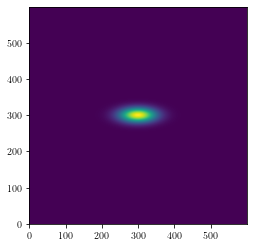

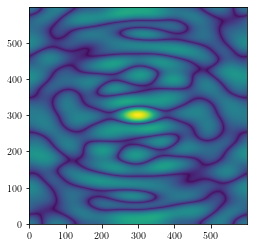

In [66]:
# EXTENDED ELLIPTICAL GAUSSIAN SOURCE

axis1 = 2 # change height of source
axis2 = 5 # change width of source

r = np.sqrt((x/axis1)**2 + (y/axis2)**2)

sky = np.exp(-r**2 / Diam**2) # generate a Gaussian source with sigma = Diameter
im=  np.fft.fft2(np.fft.fftshift(sky))
im*= np.fft.fft2(np.fft.fftshift(PSF / np.sum(PSF)))
im = np.fft.fftshift(np.fft.ifft2(im))

plt.imshow(sky, origin='lower')
plt.show()

plt.imshow(abs(im), origin='lower',  norm=mcolors.PowerNorm(0.5))
plt.show()